# Fill sinks in a digital elevation model (DEM)
Filling sinks in a DEM is an important preprocessing step in hydrological and soil erosion modelling. Just as you wouldn't paint over a wall with holes, you wouldn't want to perform a model simulation on a DEM with sinks.

**But what is a DEM?** Imagine you have a map of a hilly area, like a model of a miniature landscape made out of LEGO pieces. Each piece represents a point on the terrain (i.e. a cell of the DEM), and its height corresponds to the elevation at that point. Some blocks are stacked higher, representing hills or mountains, while others are lower, representing valleys or plains.

<left><img src="images/dem_lego.png" width="800px">

<img src="images/sink.png" style="width: 200px; float:right"><h>**Why filling sinks is important?** Sinks in a DEM represent areas where water can accumulate without flowing out. Filling sinks ensures a continuous representation of surface water flow, which is essential for hydrological modeling. Sinks are usually errors in the DEM that arise from various sources during the data collection and processing. However, it can also result in an unrealistic representation of the landscape, especially if the sinks are natural and integral parts of the terrain. Such natural sinks are relatively uncommon, so we usually can assume that the sinks are DEM errors and they should be filled.</h>

## Import (or load) the necessary iMPACT-tools
These tools will let us load the DEM, visualize it and fill the sinks.
##### Step 1: `Import tools`

In [7]:
from scipy.ndimage import gaussian_filter  # Import Gaussian filter for smoothing data
import numpy as np  # Import NumPy for numerical operations and array handling
import numba  # Import Numba for just-in-time (JIT) compilation to speed up computations
# Import the necessary iMPACT-tools (You can also find them in the Python files stored in the */tools* folder)
from tools.plot_dem import plot3d_dem
from tools.fill_sinks import is_sink
from tools.file_IO import open_raster, save_as_raster

<img src="images/open_raster.png" style="width: 200px; float:right"><h2>Load the DEM</h2><h>We open up our digital map of the terrain  (also known as raster datasets) to extract information, such as the height of each cell, and perform various raster operations, e.g. finding out how steep a hill is or filling sinks. It also extract the `metadata` information such as the raster's spatial reference system and data type. You can use this metadata for various purposes, such as georeferencing and understanding the properties of the raster map.</h>

##### Step 2: `Open the file and plot the DEM`

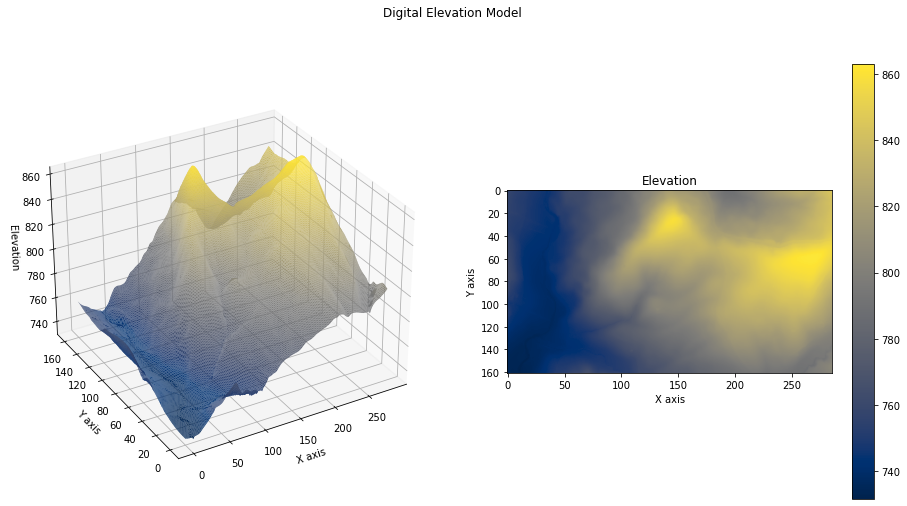

In [9]:
path = 'inputs/dem/'
file = 'dem.tif'
dem, dem_metadata = open_raster(path,file)
plot3d_dem(dem)

## Smoothen the DEM
Smoothing a Digital Elevation Model (DEM) is important for several minimizing Artifacts. DEMs often contain noise or small-scale variations due to data acquisition methods (e.g., errors in satellite or LiDAR data). These artifacts can lead to unrealistic flow patterns. A Gaussian filter helps to reduce these minor fluctuations, resulting in a more reliable representation of the terrain's overall shape.

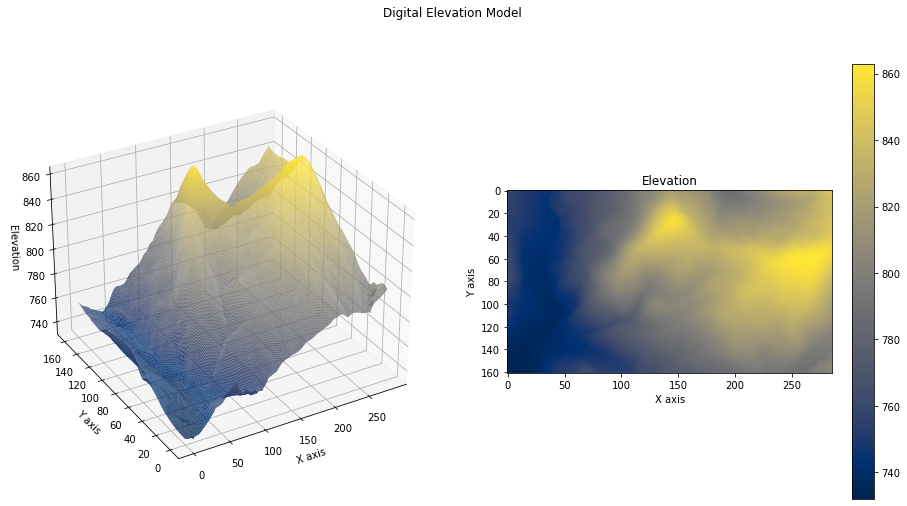

In [10]:
# Apply a Gaussian filter to smooth the DEM data
sigma = 0.5  # Standard deviation for Gaussian kernel
dem = gaussian_filter(dem, sigma=sigma)
plot3d_dem(dem)

## Fill the sinks of the DEM
In this step we perform the sink filling on the digital elevation model (DEM) and visualize the filled DEM (compare it with the DEM before filling). 
The `fill_sinks` function works like this:
- The function looks at each location on the map. If it finds a low point (a sink), it raises it up by filling it with soil so that it becomes as high as the surrounding ground. 
- It keeps doing this until all low points are filled and there are no more sinks in the landscape. To decide how high to fill each low point, it checks the heights of the neighboring locations in all directions (up, down, left, right, and diagonally) to make sure it's filling the low point properly.

In [11]:
@numba.njit
def fill_sinks(dem):
    """
    Function to fill sinks in a Digital Elevation Model (DEM).
    
    First, it finds the lowest point on the map. Then, it goes through each 
    point on the map and checks if it's a sink (where water would stop and get 
    stored). If it finds a sink, it raises that point to the same height as the 
    surrounding lowest point. It keeps doing this until there are no more sinks 
    left on the map. Essentially, it's like filling in low spots on the map to 
    make sure water flows smoothly without getting stuck.
    
    Args:
    - dem: 2D numpy array representing the DEM
    
    Returns:
    - Filled DEM with sinks removed
    """
    rows, cols = dem.shape  # Get the dimensions of the DEM (rows, cols)
    
    while True:  # Repeat until no more sinks are found
        found_sinks = False  # We first assume that no sinks are present
        # Loop through each cell in the DEM (except for the limits of the DEM)
        for x in range(1, rows - 1):
            for y in range(1, cols - 1):
                if not np.isnan(dem[x, y]):  # Check if the elevation is not a NaN value.
                    sink, min_neigh_elev = is_sink(x, y, dem)  # Run function to check if the cell is a sink
                    # Check if the cell is a sink
                    if sink:
                        dem[x, y] = min_neigh_elev  # Update the elevation of the sink cell to the minimum 
                        # elevation among its neighbors.
                        found_sinks = True  # Set the flag to True indicating that a sink has been found 

        # Break the loop if no more sinks are found (found_sinks remains False)
        if not found_sinks:
            break
    return dem

##### Step 3: `Run the function to fill the sinks and plot the filled DEM`

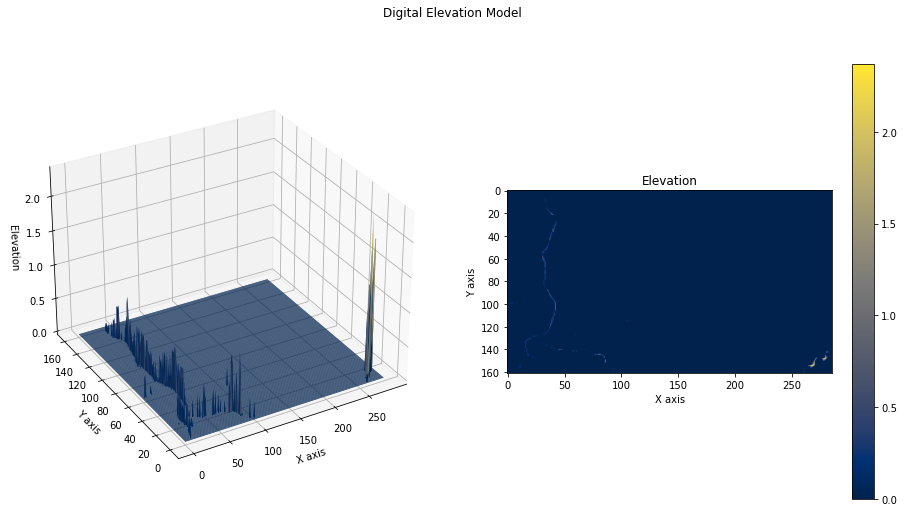

In [12]:
# The filled DEM is saved as dem_fill
dem_fill = fill_sinks(dem.copy())
# Plot only the filled areas (difference between the filled DEM and the original DEM)
plot3d_dem(dem_fill-dem)


<left><img src="images/save_raster.png" style="width: 200px; float:right"><h2>Save the filled DEM as a raster file</h2>

<h>You've just finished filling the sinks and now you want to keep a record of your work.

Just like how a photograph preserves the image you see, saving the filled DEM as a raster file preserves all the elevation data and changes you've made to the map. So, for the next modelling steps (or to share it with others), you can load the raster file, explore and modifiy the information over and over.</h>
##### Step 4: `Save the filled DEM`

In [13]:
save_as_raster(path,'filled_'+file,dem_fill,dem_metadata)